In [38]:
import os
import sys
sys.path.append("..")

In [39]:
from model import YModel, R
from gan import Generator, Discriminator, WSDiscriminator, GANLosses
from metrics import Metrics
from utils import sample_noise, iterate_minibatches, generate_data

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda", 0)


In [40]:
from comet_ml import API
import comet_ml

%matplotlib inline

In [41]:
from collections import defaultdict

In [42]:
def extract_metrics(exp, hyper_params, metrics, mask):
    for metric in exp.data['metrics']:
        metric_values = np.array(list(zip(*exp.metrics_raw[metric]))[1])
        metrics[metric].append([metric_values[mask], hyper_params['data_size']])

In [45]:
#mask = list(np.arange(0, 20)) + [50] + [100]
mask = list(np.arange(995))

In [46]:
comet_api = API()
comet_api.get()
metrics = defaultdict(list)
for experiment in comet_api.get("shir994/hetero-plots/"):
    
    hyper_params = {}
    for param in experiment.parameters:
        hyper_params[param["name"]] = param["valueMin"]
    
    extract_metrics(experiment, hyper_params, metrics, mask)

In [8]:
# plt.figure(figsize=(12,6))
# plt.pcolormesh(range(0,30), sizes, data, cmap=my_cmap);
# plt.colorbar()
# plt.yscale("log")

In [10]:
# metrics = list(zip(*exp.metrics_raw["train_average_mu_JS"]))
# plt.plot(*metrics);

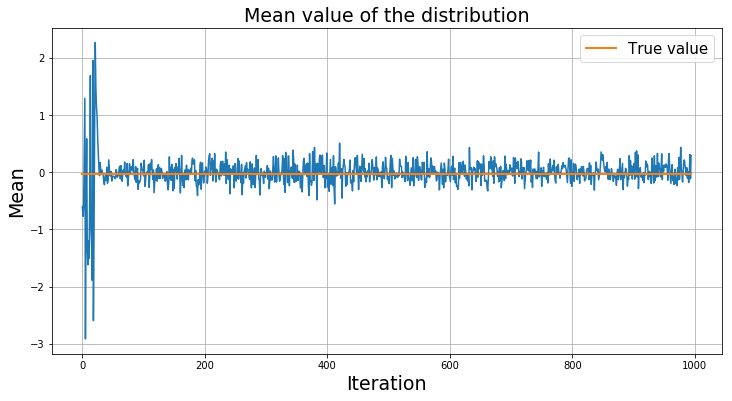

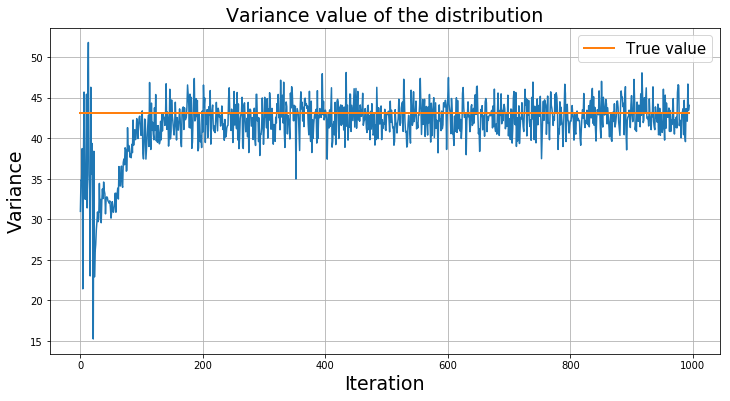

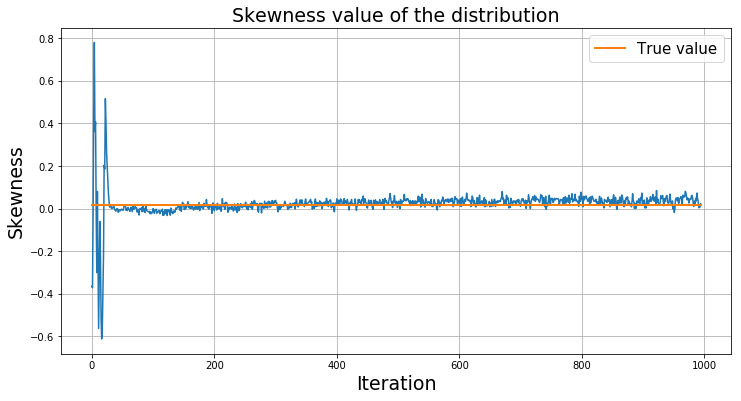

In [56]:
titles = ["Mean", "Variance", "Skewness"]
for i, title in zip(range(1,4), titles):
    plt.figure(figsize=(12,6))
    plt.plot(metrics['train_data_gen_order_{}'.format(i)][0][0])
    plt.grid()
    plt.xlabel("Iteration", fontsize=19)
    plt.ylabel("{}".format(title), fontsize=19)
    plt.title("{} value of the distribution".format(title), fontsize=19);
    plt.plot((metrics['train_data_diff_order_{}'.format(i)][0][0] + metrics['train_data_gen_order_{}'.format(i)][0][0]),
             label='True value', linewidth=2)
    plt.legend(fontsize=15)
    plt.savefig("plots/{}.pdf".format(title))

# Test on mu outside of training domain

In [48]:
exp = comet_api.get("shir994/hetero-plots/7292f56395734c669702a43657f1a758")
hyper_params = {}
for param in exp.parameters:
    hyper_params[param["name"]] = param["valueMin"]

In [49]:
TASK = int(hyper_params['TASK'])
NOISE_DIM = int(hyper_params["NOISE_DIM"])

In [50]:
generator = Generator(NOISE_DIM, out_dim = 1).to(device)
if TASK == 4:
    discriminator = WSDiscriminator(in_dim=1).to(device)
else:
    discriminator = Discriminator(in_dim=1).to(device)

y_sampler = YModel()
fixed_noise = torch.Tensor(sample_noise(10000, NOISE_DIM)).to(device)
metric_calc = Metrics((-50, 50), 100)

In [51]:
import io

asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == "hetero_plots.tar"][0]
params = exp.get_asset(asset_id)
state_dict = torch.load(io.BytesIO(params))

In [52]:
state_dict.keys()

dict_keys(['gen_state_dict', 'dis_state_dict', 'genopt_state_dict', 'disopt_state_dict', 'epoch'])

In [53]:
generator.load_state_dict(state_dict['gen_state_dict'])

In [57]:
def make_plot(order, title):
    trues = []
    gens = []
    for x in np.arange(-10, 10, 0.1):
        input_mu = torch.full(size=(10000, ), fill_value=-0.).to(device)
        input_x = torch.full(size=(10000, ), fill_value=x).to(device)

        y_sampler.make_condition_sample({'X':input_x})
        data = y_sampler.condition_sample().detach().cpu().reshape(-1,1)
        true_val = metric_calc.compute_moment(data, order)
        trues.append(true_val)

        gen = generator(fixed_noise, torch.stack([input_mu, input_x], dim=1)).detach().cpu()
        gen_val = metric_calc.compute_moment(gen, order)
        gens.append(gen_val)

    plt.figure(figsize=(12,6))
    plt.plot(np.arange(-10, 10, 0.1), gens, label='Generated')
    plt.plot(np.arange(-10, 10, 0.1), trues, label='True')

    plt.grid()
    plt.xlabel("Input X", fontsize=19)
    plt.ylabel("{}".format(title), fontsize=19)
    plt.title("{} value of the distribution".format(title), fontsize=19);
    plt.legend(fontsize=15)
    plt.savefig("plots/{}_as_x.pdf".format(title))

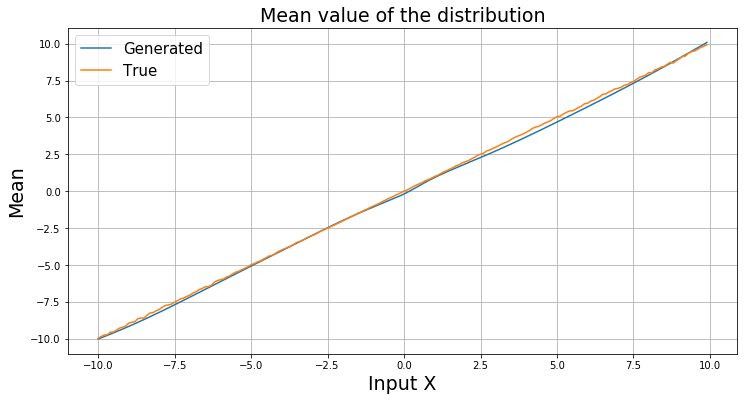

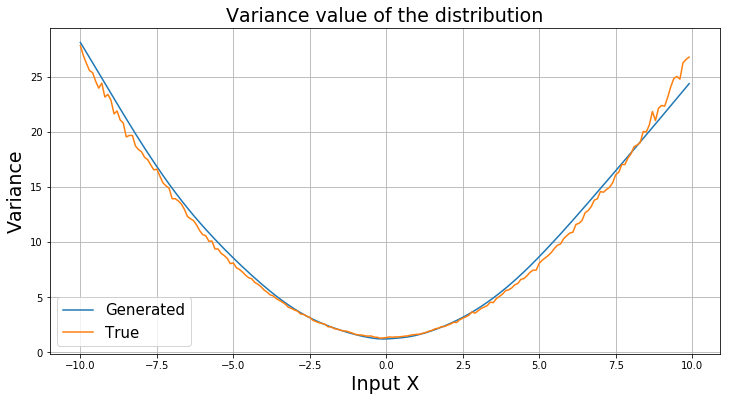

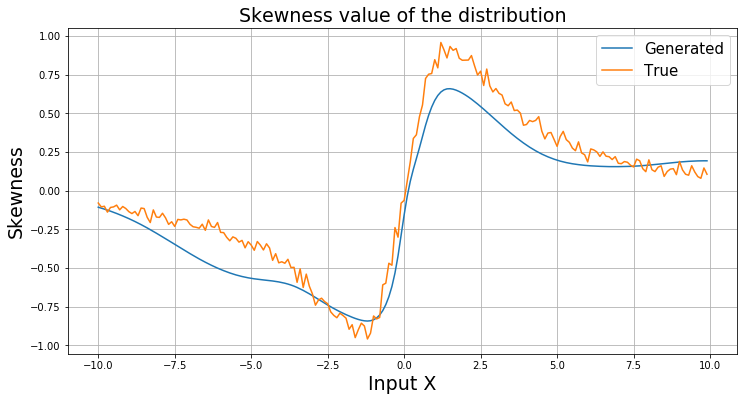

In [58]:
make_plot(1, "Mean");
make_plot(2, "Variance")
make_plot(3, "Skewness")